## Suppression des doublons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("../data/raw/spotify_dataset_train.csv")

# Contamos duplicados antes
print(f"Valeurs dupliquées auparavant : {df_train.duplicated(subset=df_train.columns).sum()}")

# Eliminamos manteniendo la primera aparición
df = df_train.drop_duplicates(subset=df_train.columns, keep='first')

print(f"Lignes restantes : {df.shape[0]}")

Valeurs dupliquées auparavant : 1
Lignes restantes : 25491


## Preprocessing

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
class MusicFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):  # Corrección de sintaxis
        pass # No necesitamos guardar estado si extraemos solo el año

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Conversión a datetime
        # 'coerce' transforma errores en NaT para evitar rupturas
        X_copy['release_date'] = pd.to_datetime(X_copy['release_date'], format='mixed', errors='coerce')
        
        # Extracción de Año (Más robusto que días exactos para géneros)
        X_copy['release_year'] = X_copy['release_date'].dt.year.fillna(0).astype(int)
        # Boolean to Int
        if 'explicit' in X_copy.columns:
            X_copy['explicit'] = X_copy['explicit'].astype(int)

        # Drop columns (incluyendo 'key' como acordamos)
        cols_to_drop = ['release_date']
        X_copy = X_copy.drop(columns=[c for c in cols_to_drop if c in X_copy.columns], errors='ignore')
        
        return X_copy
    
    '''
    L'idée de cette fonction est de prendre les valeurs aberrantes statistiques, 
    c'est-à-dire celles qui dépassent 1,5XQ1 ou 1,5XQ3, et de fixer artificiellement leur valeur à 
    l'extrémité du quartile, afin d'éviter les valeurs très éloignées.
    '''
def cap_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Nous appliquons le plafonnement (Winsorisation)
        # Les valeurs inférieures à la limite inférieure deviennent la limite inférieure.
        # Les valeurs supérieures à la limite supérieure deviennent la limite supérieure.
        df_clean[col] = df_clean[col].clip(lower=lower_limit, upper=upper_limit)
        
    return df_clean



In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# Colonnes avec les outliers les plus problématiques
#cols_to_fix = ['energy', 'loudness','speechiness','instrumentalness','duration_ms'] 
#df_train = cap_outliers(df_train, cols_to_fix)

# Ejecución del Pipeline
df_train = pd.read_csv("../data/raw/spotify_dataset_train.csv")
X = df_train.drop(columns=['genre'])
y = df_train['genre']
features = X.columns
# Pipeline de Preprocesamiento
pipeline_preprocessing = Pipeline([
    ('feature_eng', MusicFeatureEngineering()),
    ('scaler', RobustScaler())
])

# Label Encoding para el Target
label_encoder_y = LabelEncoder()

X_processed = pipeline_preprocessing.fit_transform(X)
y_encoded = label_encoder_y.fit_transform(y)

In [5]:
cols_to_drop = ['release_date']
features= [col for col in features if col not in cols_to_drop]
features.append('release_year')
features

['explicit',
 'popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'release_year']

## Splitting

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, 
    y_encoded, 
    test_size=0.2, 
    stratify=y_encoded, 
    random_state=42
)


## Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [8]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fitting
rf_model.fit(X_train, y_train)
# Predict
y_pred = rf_model.predict(X_test)

genres = label_encoder_y.classes_
# Evaluation
print(f"Global F1: {f1_score(y_test, y_pred,average='micro'):.4f}")
#0.4611 random forest sans augmentation des données et standard scaler
#0.4672 random forest sans augmentation des données et robust scaler et tous les caracteristiques


Global F1: 0.4672


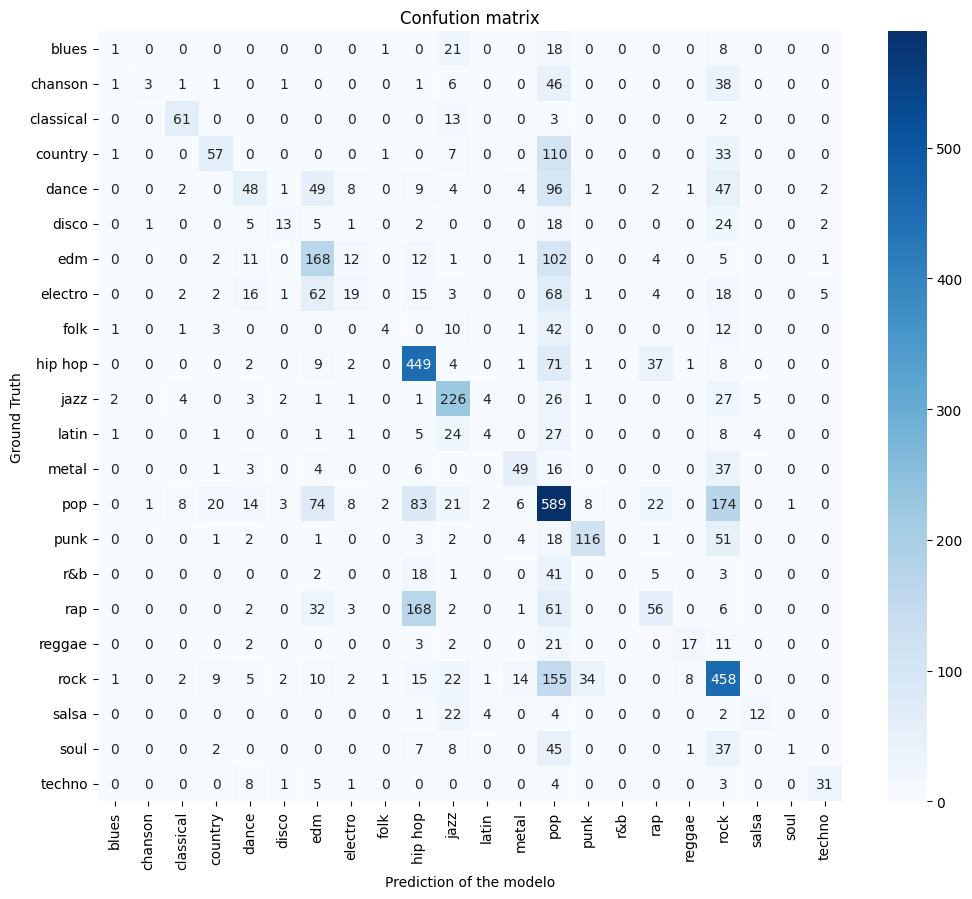

In [15]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=genres,  
    yticklabels=genres  
)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction of the modelo')
plt.title('Confution matrix')
plt.show()

## Feature Importance

C:\Users\alfar\AppData\Local\Temp\ipykernel_13768\1596778747.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


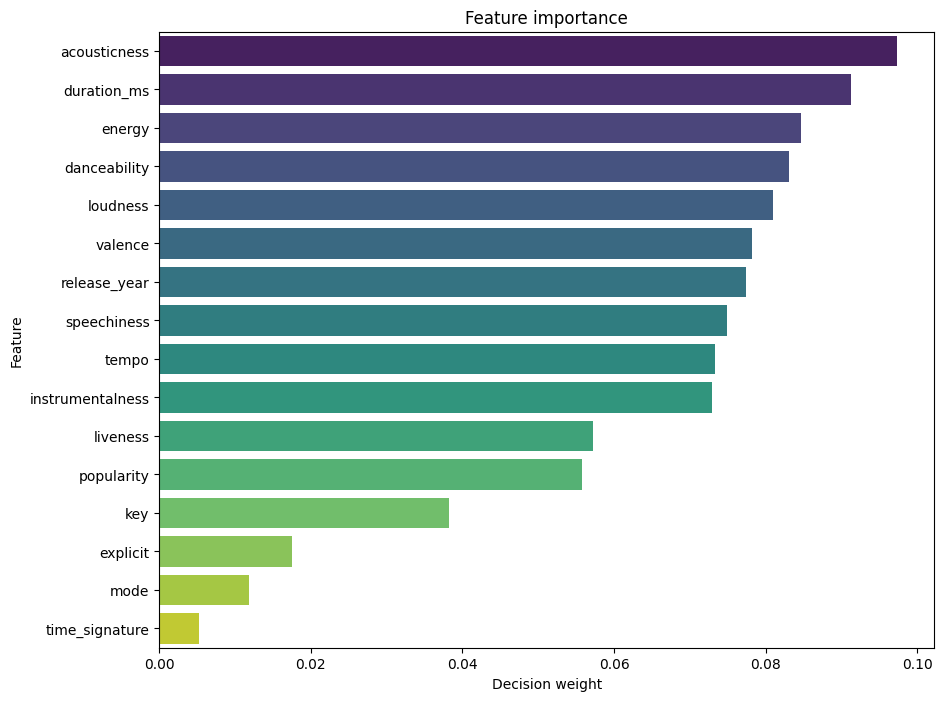

In [9]:

importances = rf_model.feature_importances_
# Creamos un DataFrame para ordenar los datos
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# 3. Graficamos
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature importance')
plt.xlabel('Decision weight')
plt.ylabel('Feature')
plt.show()

## SMOTE Random forest

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# 3. APLICAR SMOTE (La magia ocurre aquí)
print("Generando datos sintéticos con SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Entrenando con {len(y_train_resampled)} muestras (antes eran {len(y_train)})")

# 4. Entrenar
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_resampled, y_train_resampled)

# 5. Evaluar
y_pred_smote = rf_smote.predict(X_test)
print(f"Global F1: {f1_score(y_test, y_pred_smote,average='micro'):.4f}")

Generando datos sintéticos con SMOTE...
Entrenando con 91190 muestras (antes eran 20393)
Global F1: 0.4273


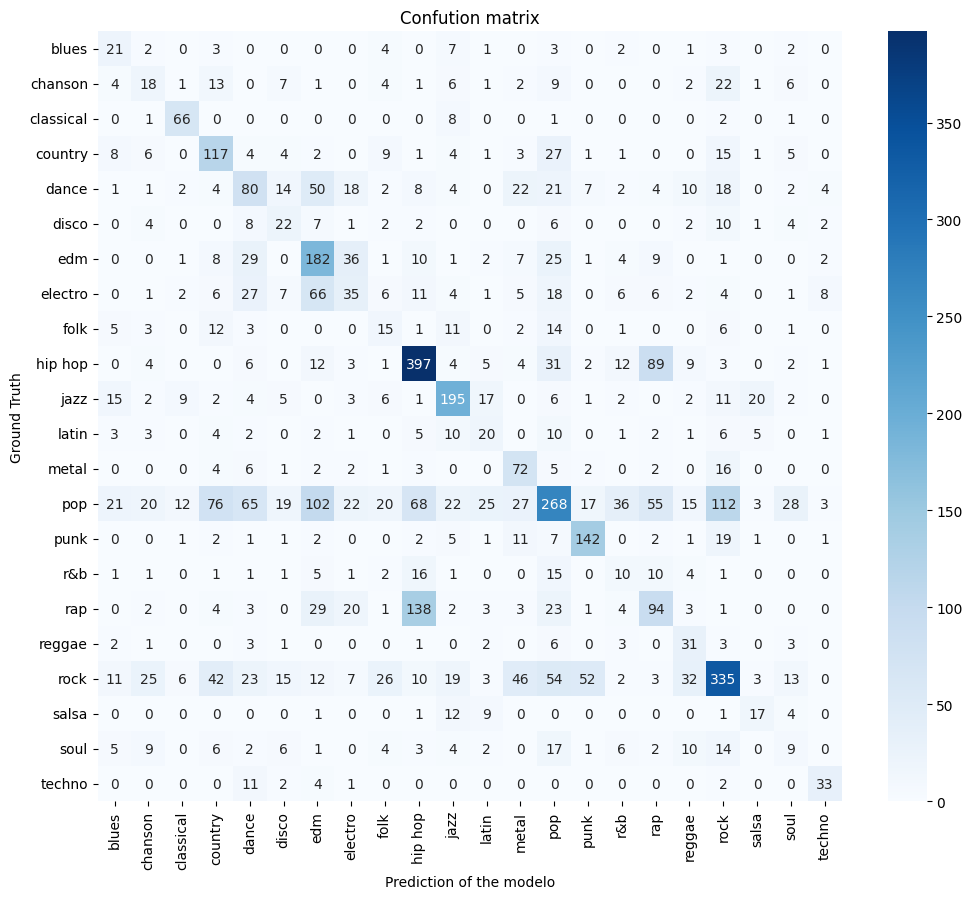

In [18]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=genres,  
    yticklabels=genres  
)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction of the modelo')
plt.title('Confution matrix')
plt.show()

## Balance Random Forest

In [16]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Instanciamos el Balanced Random Forest
# sampling_strategy='all' intenta equilibrar todas las clases en cada árbol
brf_model = BalancedRandomForestClassifier(
    n_estimators=1000,       # Más árboles ayuda a cubrir más datos de la clase mayoritaria
    replacement=True,      # Muestreo sin reemplazo (toma datos distintos)
    sampling_strategy='all',
    random_state=42,
    n_jobs=-1               # Usa todos los núcleos de tu CPU para ir rápido
)

print("Entrenando Balanced Random Forest (Undersampling inteligente)...")
brf_model.fit(X_train, y_train)

# 3. Evaluar
y_pred_brf = brf_model.predict(X_test)

print("-" * 30)
print(f"Global F1: {f1_score(y_test, y_pred_brf,average='micro'):.4f}")

Entrenando Balanced Random Forest (Undersampling inteligente)...
------------------------------
Global F1: 0.3671


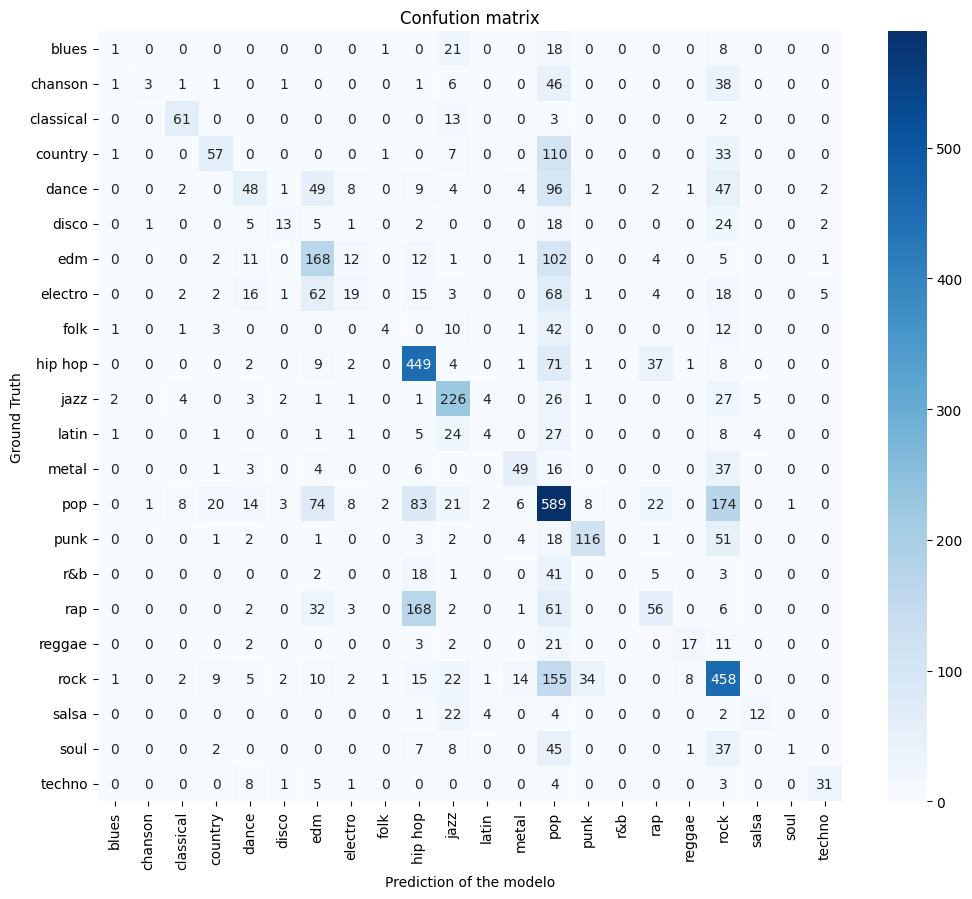

In [19]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=genres,  
    yticklabels=genres  
)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction of the modelo')
plt.title('Confution matrix')
plt.show()

## XGBOOST

In [14]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder_y.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# 3. Optimización de Hiperparámetros (Tuning)
# Random Forest usa parámetros por defecto decentes, pero XGBoost NECESITA tuning.
param_dist = {
    'n_estimators': [100, 200, 300],        # Número de árboles
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Qué tan rápido aprende (menor es más preciso pero lento)
    'max_depth': [3, 5, 7, 10],             # Profundidad del árbol (muy profundo = overfitting)
    'subsample': [0.7, 0.8, 1.0],           # Cuantos datos usa por árbol
    'colsample_bytree': [0.7, 0.8, 1.0]     # Cuantas columnas usa por árbol
}

# Usamos RandomizedSearchCV para buscar la mejor combinación sin tardar años
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=15,             # Probará 15 combinaciones aleatorias
    scoring='f1_weighted', # ¡Optimizamos directamente para F1!
    cv=3,                  # Validación cruzada de 3 pliegues
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

print("Buscando los mejores hiperparámetros para XGBoost...")
random_search.fit(X_train, y_train)

# 4. Mejor modelo y evaluación
best_model = random_search.best_estimator_
print(f"Mejores parámetros: {random_search.best_params_}")

y_pred_xgb = best_model.predict(X_test)

print("-" * 30)
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder_y.classes_))

Buscando los mejores hiperparámetros para XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\alfar\OneDrive\Escritorio\IMT\PREMIERE ANNEE\AARES\Projet AARES-20260202\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:53:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=genres,  
    yticklabels=genres  
)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction of the modelo')
plt.title('Confution matrix')
plt.show()